# Using scTour to infer cellular dynamics

## For version 1.0.0

This tutorial is for version 1.0.0 where prediction functionalities have been separated from inference. Please follow `Installation` to install the latest version (1.0.0).

## Dataset

This notebook uses the dataset from the developing human cortex ([Trevino et al., 2021, Cell](https://www.cell.com/cell/fulltext/S0092-8674(21)00942-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867421009429%3Fshowall%3Dtrue)) to show the basic inference functionalities of scTour. This data ('EX_development_human_cortex_10X.h5ad') can be downloaded from [here](https://drive.google.com/drive/folders/1zGr_Gqio8zpJWAdLj0g66kN004PyYq_x?usp=sharing).

In [1]:
import sctour as sct
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
adata = sc.read('../../../../EX_development_data/EX_development_human_cortex_10X.h5ad')
adata.shape

(36318, 19073)

This dataset has substantial batch effect as shown below.

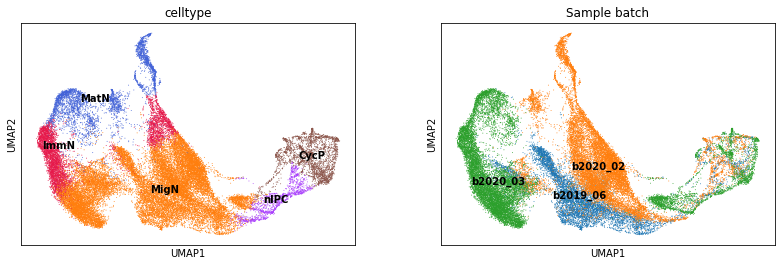

In [3]:
sc.pl.umap(adata, color=['celltype', 'Sample batch'], legend_loc='on data')

## Model training

Count the number of genes detected in each cell. This step is required before the scTour model training.

In [4]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

Select highly variable genes.

In [5]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=1000, subset=True)

/home/ql312/software/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Now we are ready to train the scTour model. The default `loss_mode` is negative binomial conditioned likelihood (`nb`), which requires raw UMI counts (stored in `.X` of the AnnData) as input. By default, the percentage of cells used to train the model is set to 0.9 when the total number of cells is less than 10,000 and 0.2 when greater than 10,000. Users can adjust the percentage by using the parameter `percent` (for example percent=0.6).

There are two parameters `alpha_recon_lec` and `alpha_recon_lode` for balancing the reconstruction errors from encoder-derived latent space and from ODE-solver-derived latent space. A small `alpha_recon_lec` (with a small weight assigned to the reconstruction error from encoder-derived latent space) tends to derive latent representations that order the cells based on their pseudotime and thus cannot well separate cell types with similar developmental orders. The default values for these two parameters are 0.5. Users can adjust them depending on datasets.

In [6]:
tnode = sct.train.Trainer(adata, loss_mode='nb', alpha_recon_lec=0.5, alpha_recon_lode=0.5)
tnode.train()

Epoch 400: 100%|██████████| 400/400 [20:20<00:00,  3.04s/epoch, train_loss=269, val_loss=265]


## Infer cellular dynamics

### pseudotime

Infer the developmental pseudotime based on the trained model.

In [7]:
adata.obs['ptime'] = tnode.get_time()

The pseudotime might be returned in reverse order due to the two possible directions for integration when solving an ODE. If this happens, please refer to tutorial `scTour inference – Post-inference adjustment` for how to correct the ordering.

### latent space

Infer the latent representations. The two parameters `alpha_z` and `alpha_predz` adjust the weights given to the latent space from variational inference and that from ODE solver. Larger `alpha_z` skews the latent space towards the intrinsic transcriptomic structure while larger `alpha_predz` is more representative of the extrinsic pseudotime ordering. Users can adjust the two parameters according to their purposes.

In [8]:
#zs represents the latent z from variational inference, and pred_zs represents the latent z from ODE solver
#mix_zs represents the weighted combination of the two, which is used for downstream analysis
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.5, alpha_predz=0.5)
adata.obsm['X_TNODE'] = mix_zs

### vector field

Infer the transcriptomic vector field.

In [9]:
adata.obsm['X_VF'] = tnode.get_vector_field(adata.obs['ptime'].values, adata.obsm['X_TNODE'])

## Visualization

Generate a UMAP embedding based on the inferred latent space. Optionally, you can order the cells according to their pseudotime before this step, which may yield a better trajectory for some datasets. (You can also use your own UMAP to visualize the cellular dynamics inferred.)

In [10]:
adata = adata[np.argsort(adata.obs['ptime'].values), :]
sc.pp.neighbors(adata, use_rep='X_TNODE', n_neighbors=15)
sc.tl.umap(adata, min_dist=0.1)

Visualize the clusters, sample batches, pseudotime and vector field on the UMAP. When visualizing the vector field, information from the estimated pseudotime can be optionally incorporated by providing the parameter `t_key` (for example `t_key='ptime'` where `ptime` is the pseudotime stored in `.obs`).

As shown below, the inference by scTour is largely unaffected by batch effects.

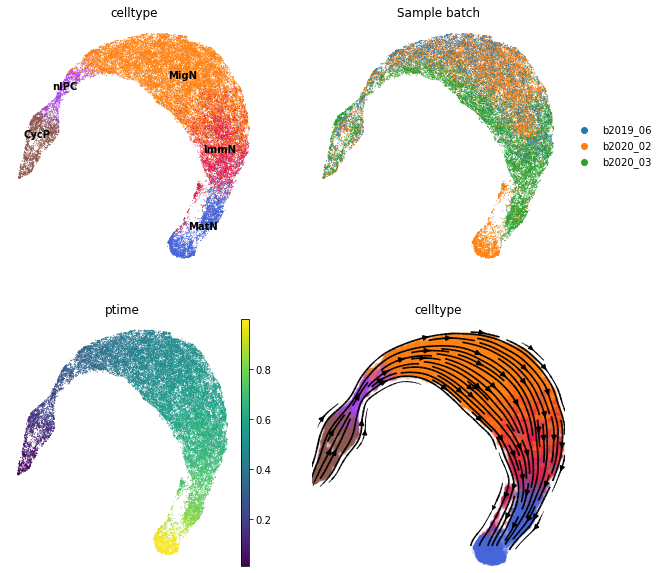

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
sc.pl.umap(adata, color='celltype', ax=axs[0, 0], legend_loc='on data', show=False, frameon=False)
sc.pl.umap(adata, color='Sample batch', ax=axs[0, 1], show=False, frameon=False)
sc.pl.umap(adata, color='ptime', ax=axs[1, 0], show=False, frameon=False)
sct.vf.plot_vector_field(adata, zs_key='X_TNODE', vf_key='X_VF', use_rep_neigh='X_TNODE', color='celltype', show=False, ax=axs[1, 1], legend_loc='none', frameon=False, size=100, alpha=0.2)
plt.show()                                                                                            

## Robustness to random initializations

For some datasets, the inferred cellular dynamics by scTour may vary when the model is initialized differently. To check the robustness of the cellular dynamics inferred to random initializations, you can run the training process 10 times by providing different seeds for generating random numbers using the parameter `random_state` in `sct.train.Trainer`. You can then check the pseudotime, vector field and latent representations derived from each of these 10 models to see whether the inference is stable or not. If not, you can possibly choose the one with the highest frequency.